<a href="https://colab.research.google.com/github/NeuralNetGeek/ml-monkeypox/blob/main/Monkey_Pox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import shap
import matplotlib.pyplot as plt

DATA COLLECTION

The dataset was sourced from https://www.kaggle.com/datasets/muhammad4hmed/monkeypox-patients-dataset

DATA CLEANING, EXPLORATION AND PREPROCESSING

In [55]:
cols = ['Patient_ID', 'Systemic Illness', 'Rectal Pain', 'Sore Throat', 'Penile Oedema', 'Oral Lesions', 'Solitary Lesion', 'Swollen Tonsils', 'HIV Infection', 'Sexually Transmitted Infection', 'MonkeyPox']
df = pd.read_csv('monkey.data.csv')
df.columns = cols
df.drop(['Patient_ID', 'Systemic Illness'], axis=1, inplace=True)
df.drop_duplicates(inplace=True)

features = ['Rectal Pain', 'Sore Throat', 'Penile Oedema', 'Oral Lesions', 'Solitary Lesion', 'Swollen Tonsils', 'HIV Infection', 'Sexually Transmitted Infection']

df[features] = df[features].astype(int)

df['MonkeyPox'] = df['MonkeyPox'].map({'Positive': 1, 'Negative': 0})

df.head(10)

,Rectal Pain,Sore Throat,Penile Oedema,Oral Lesions,Solitary Lesion,Swollen Tonsils,HIV Infection,Sexually Transmitted Infection,MonkeyPox
0,0,1,1,1,0,1,0,0,0
1,1,0,1,1,0,0,1,0,1
2,0,1,1,0,0,0,1,0,1
3,1,0,0,0,1,1,1,0,1
4,1,1,1,0,0,1,1,0,1
5,0,1,0,0,0,0,0,0,0
6,0,1,0,0,0,0,1,0,1
7,1,1,0,1,1,1,0,0,1
8,0,1,1,1,0,0,0,0,1
9,0,0,1,1,1,0,1,0,0


In [56]:
df['MonkeyPox'].value_counts()

,count
MonkeyPox,
0,256
1,256


In [57]:
features_encoded = ['Rectal Pain', 'Sore Throat', 'Penile Oedema', 'Oral Lesions', 'Solitary Lesion', 'Swollen Tonsils', 'HIV Infection', 'Sexually Transmitted Infection']
target = 'MonkeyPox'

X = df[features_encoded]
y = df[target]

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

TRAIN, VALID AND TEST

In [58]:
def evaluate_classifiers(models, X, y, show_reports=True):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    summary = []

    for name, model in models.items():
        try:
            cv_scores = cross_validate(model, X, y, cv=skf, scoring='f1')
            mean_cv_score = cv_scores['test_score'].mean()

            model.fit(X, y)
            y_pred = model.predict(X)

            acc = accuracy_score(y, y_pred)
            prec = precision_score(y, y_pred, zero_division=0)
            rec = recall_score(y, y_pred, zero_division=0)
            f1 = f1_score(y, y_pred, zero_division=0)

            roc_auc = np.nan
            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X)[:, 1]
                if len(np.unique(y)) > 1:
                    roc_auc = roc_auc_score(y, y_prob)

            summary.append({
                'Model': name,
                'Accuracy': acc,
                'Precision': prec,
                'Recall': rec,
                'F1 Score': f1,
                'ROC-AUC': roc_auc,
                'Cross-Validation F1 Mean': mean_cv_score
            })

            if show_reports:
                print(f"\nModel: {name}")
                print(f"Cross-Validation F1 Mean: {mean_cv_score:.4f}")
                print("Confusion Matrix:")
                print(confusion_matrix(y, y_pred))
                print("\nClassification Report:")
                print(classification_report(y, y_pred, zero_division=0))

        except Exception as e:
            print(f"\nError with {name}: {e}")
            summary.append({
                'Model': name,
                'Accuracy': np.nan,
                'Precision': np.nan,
                'Recall': np.nan,
                'F1 Score': np.nan,
                'ROC-AUC': np.nan,
                'Cross-Validation F1 Mean': np.nan
            })

    return pd.DataFrame(summary)

models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', class_weight='balanced'),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Support Vector Machine": SVC(C=1.0, kernel='rbf', gamma='scale', class_weight='balanced', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', max_features=0.7,  random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(learning_rate=0.05, l2_regularization=1.0, max_iter=200, random_state=42)
}

In [59]:
results = evaluate_classifiers(models, X_train, y_train)
print("\nModel Performance Summary:")
print(results)


Model: Logistic Regression
Cross-Validation F1 Mean: 0.4466
Confusion Matrix:
[[82 71]
 [74 79]]

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.54      0.53       153
           1       0.53      0.52      0.52       153

    accuracy                           0.53       306
   macro avg       0.53      0.53      0.53       306
weighted avg       0.53      0.53      0.53       306


Model: K-Nearest Neighbors
Cross-Validation F1 Mean: 0.4054
Confusion Matrix:
[[91 62]
 [66 87]]

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.59      0.59       153
           1       0.58      0.57      0.58       153

    accuracy                           0.58       306
   macro avg       0.58      0.58      0.58       306
weighted avg       0.58      0.58      0.58       306


Model: Naive Bayes
Cross-Validation F1 Mean: 0.4422
Confusion Matrix:
[[81 72]
 [73 80]]

Classificat

In [60]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10, 12, 15, 20, 22, 25, 30],
    'min_samples_leaf': [1, 2]
}

rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
r_rand = RandomizedSearchCV(rf_model, rf_params, n_iter=10, cv=5, scoring='f1', n_jobs=-1, verbose=1, random_state=42)
r_rand.fit(X_train, y_train)

print("Best Parameters:", r_rand.best_params_)
print("Best Score:", r_rand.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 22, 'min_samples_leaf': 2, 'max_depth': 10}
Best Score: 0.40221692533149705


In [61]:
hgb_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [20, 30, 50]
}

hgb_model = HistGradientBoostingClassifier(random_state=42)
h_rand = RandomizedSearchCV(hgb_model, hgb_params, n_iter=10, cv=5, scoring='f1', n_jobs=-1, verbose=1, random_state=42)
h_rand.fit(X_train, y_train)

print("Best Parameters:", h_rand.best_params_)
print("Best Score:", h_rand.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'min_samples_leaf': 30, 'max_iter': 100, 'max_depth': 10, 'learning_rate': 0.01}
Best Score: 0.4675241304995758


In [62]:
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

svm_model = SVC(class_weight='balanced', probability=True, random_state=42)
s_rand = RandomizedSearchCV(svm_model, svm_params, n_iter=10, cv=5, scoring={'F1': 'f1', 'ROC_AUC': 'roc_auc'}, refit='F1', n_jobs=-1, verbose=1, random_state=42)
s_rand.fit(X_train, y_train)

print("Best Parameters:", s_rand.best_params_)
print("Best Score:", s_rand.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.1}
Best Score: 0.4539846743295019


In [63]:
def evaluate_model(model, X_valid, y_valid):
    y_pred = model.predict(X_valid)
    y_prob = model.predict_proba(X_valid)[:, 1]

    acc = accuracy_score(y_valid, y_pred)
    prec = precision_score(y_valid, y_pred, zero_division=0)
    rec = recall_score(y_valid, y_pred, zero_division=0)
    f1 = f1_score(y_valid, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_valid, y_prob)

    return {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'ROC-AUC': roc_auc
    }

rf_valid_results = evaluate_model(r_rand.best_estimator_, X_valid, y_valid)
hgb_valid_results = evaluate_model(h_rand.best_estimator_, X_valid, y_valid)
svm_valid_results = evaluate_model(s_rand.best_estimator_, X_valid, y_valid)

In [64]:
print("RandomForest Validation metrics:", rf_valid_results)
print("HistGradientBoosting Validation metrics:", hgb_valid_results)
print("Support Vector Machine Validation metrics:", svm_valid_results)

RandomForest Validation metrics: {'Accuracy': 0.2912621359223301, 'Precision': 0.29411764705882354, 'Recall': 0.28846153846153844, 'F1 Score': 0.2912621359223301, 'ROC-AUC': np.float64(0.23981900452488691)}
HistGradientBoosting Validation metrics: {'Accuracy': 0.32038834951456313, 'Precision': 0.36363636363636365, 'Recall': 0.46153846153846156, 'F1 Score': 0.4067796610169492, 'ROC-AUC': np.float64(0.2664027149321267)}
Support Vector Machine Validation metrics: {'Accuracy': 0.4077669902912621, 'Precision': 0.41509433962264153, 'Recall': 0.4230769230769231, 'F1 Score': 0.41904761904761906, 'ROC-AUC': np.float64(0.6255656108597285)}


MonkeyPox SVM Model - SHAP Summary Plot:


/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


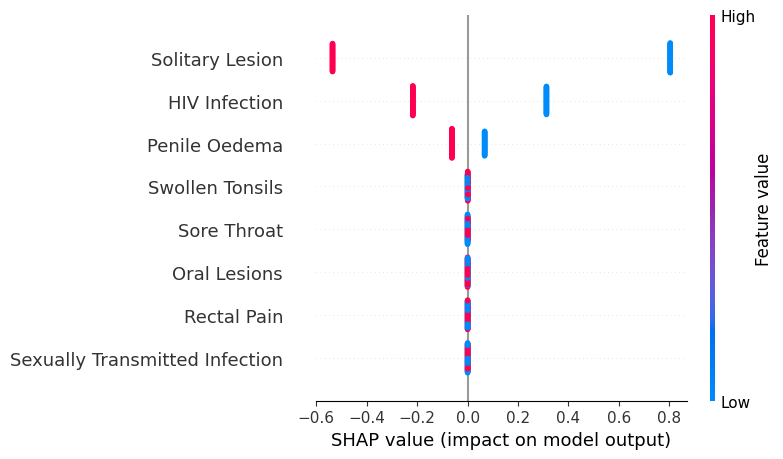

In [65]:
explainer_svm = shap.LinearExplainer(s_rand.best_estimator_, X_train, feature_perturbation="interventional")
shap_values_svm = explainer_svm.shap_values(X_valid)

print("MonkeyPox SVM Model - SHAP Summary Plot:")
shap.summary_plot(shap_values_svm, X_valid, feature_names=features_encoded)

MonkeyPox HGB Model - SHAP Summary Plot:


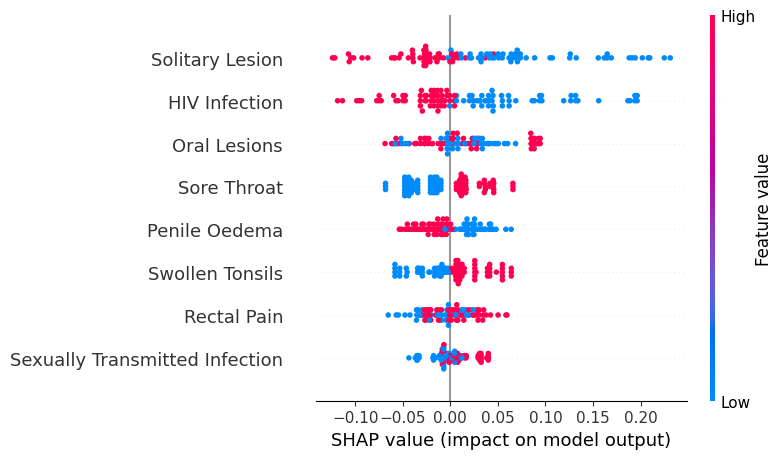

In [66]:
explainer_hgb = shap.TreeExplainer(h_rand.best_estimator_, X_train, feature_perturbation="interventional")
shap_values_hgb = explainer_hgb.shap_values(X_valid)

print("MonkeyPox HGB Model - SHAP Summary Plot:")
shap.summary_plot(shap_values_hgb, X_valid, feature_names=features_encoded)